**LSTM + ATTENTION**

***В данном ноутбуке буду рассматривать сетку encoder-decoder на основе bidirectionsl LSTM-слоев. При этом будет добавлен механизм Attention, когда декодер на каждом шаге смотрит на все выходы encoder и берет их с некоторыми весами. Веса имеют смысл схожести скрытого слоя декодера и енкодера и рассчитываются через скалярное произведение скрытого слоя декодера и скрытого слоя энкодера (с последующим применением softmax)***

# Скачиваем и обрабатываем данные 

In [ ]:
#@title
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
#@title
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(23))

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 6671
Unique tokens in target (en) vocabulary: 9264


# Определяем модель

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")
%load_ext autoreload
%autoreload 2
import utils
import attention
import pipeline_func
import imp
#imp.reload(utils)
#imp.reload(convolution_pos)
#imp.reload(pipeline_func)
from  attention import *
from pipeline_func import *
from utils import *
import pickle

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
#ENC_EMB_DIM = 128
#DEC_EMB_DIM = 128
#ENC_HID_DIM = 256
#DEC_HID_DIM = 1024
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6671, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(9264, 256)
    (rnn): LSTM(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=9264, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

The model has 28,830,000 trainable parameters


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Обучаем модель

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
from  attention import *

In [ ]:
%%time
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
   
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_best.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model_save = model

In [ ]:
#model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/models_attention/model_best_ppl_85.384.pt")
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
#model.load_state_dict(model_state)

# Оцениваем результаты

In [ ]:
%%time
BATCH_SIZE_test = 32


train_iterator1, valid_iterator1, test_iterator1 = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE_test, 
    device = device,
    sort_key=_len_sort_key
)

test_loss = evaluate(model, test_iterator1, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 9.134 | Test PPL: 9264.244 |
CPU times: user 7.34 s, sys: 210 ms, total: 7.55 s
Wall time: 7.54 s


In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm



In [ ]:
(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

15.517836650839245

In [ ]:
for i, (orig_txt, gen_txt) in enumerate(zip(original_text, generated_text)):
  if i > 150:
    break
  print(" ".join(orig_txt))
  print(" ".join(gen_txt))
  print("\n")

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

In [ ]:
(original_text_train, generated_text_train) = generate_translation(model, train_iterator, TRG.vocab)

In [ ]:
for i, (orig_txt, gen_txt) in enumerate(zip(original_text_train, generated_text_train)):
  if i > 150:
    break
  print(" ".join(orig_txt))
  print(" ".join(gen_txt))
  print("\n")

In [ ]:
corpus_bleu([[text] for text in original_text_train], generated_text_train) * 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/", f"lab2_attention_bleu15.0.tgz")
           )       

# Выводы

**Получили следующие показатели для модели**
```
**Train Loss: 1.695 | Train PPL:   5.448 | Train Bleu 33.06**

**Test Loss: 4.344 | Test PPL:  77.043 | Test Bleu 28.187**
```
**Удачные переводы:**

услуги горничной предоставляются ежедневно .   
ежедневно предоставляются услуги горничной .

**Радуют вот такие переводы:**

на территории гостевого дома есть открытый бассейн .  
гости могут плавать в открытом бассейне.

в числе удобств — терраса и бесплатная частная парковка .  
к услугам гостей бесплатная частная парковка .

**Неудачные переводы:**  
в числе удобств — собственная ванная комната .  
в собственной ванной комнате установлен собственная ванная комната .

производится доставка еды и напитков в номер .  
производится обслуживание номеров производится обслуживание номеров .

**Cкорость обучения модели:**  
(число эпох * число обработанных батчей за одну эпоху * размер батча):
10 * 40000 (~312 батчей по 128) 

**Время:**
```
Epoch: 10 | Time: 3m 26s
	Train Loss: 1.695 | Train PPL:   5.448
	 Val. Loss: 4.447 |  Val. PPL:  85.384
CPU times: user 31min 35s, sys: 3min 2s, total: 34min 37s
Wall time: 34min 33s
```
**Оцените степень переобучения модели**  
На трейне loss намного ниже, чем на валидейшене или тесте 1.6 против 4.3-4.4.Переобучение есть, но берем то значение весов, когда loss на валидейшене минимальное (до начала переобучения)

**Оцените скорость применения модели в режиме inference**  
в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)

Для батчей размером 32:
CPU times: user 8.36 s, sys: 455 ms, total: 8.82 s
Wall time: 8.8 s

**Были проведены следующие подэксперименты по fine-tuning сетки**

*   **Изменяла процент подачи в LSTM-блок новых слов, полученных из предыдущих блоков и слов из предложения (teacher_forcing) - при этом при увеличении количества слов, поданных "извне"  - сеть давала лучшие результаты на тренировочных данных и худшие на валидации (то есть лучше подстраивалась под train тексты и обучалась на них).**

*  **Менялись такие параметры как размер скытого слоя, размер embedding.**
*  **Здесь, как и в других моделях, очень важным оказалась инициализация весов. Небольшой начальный разброс значений обеспечиваает лучшую сходимость, чем если просто проинициализировать их одинаково нулями. Это дает разное значение градиента в разных параметрах**



In [ ]:
model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/lab2_attention_bleu28.0.tgz")
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [ ]:
model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/lab2_attention_bleu15.0.tgz")
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [ ]:
def compute_reward(trg, translations, TRG_vocab):
    """ computes sample-wise reward given token ids for inputs and translations """
    #distances = list(map(get_distance,
    #                     inp_voc.to_lines(input_sequence.data.numpy()),
    #                     out_voc.to_lines(translations.data.numpy())))
    # use negative levenshtein distance so that larger reward means better policy
    original_text = []
    generated_text = []
    #print(trg.shape)
    #print(translations.shape)
    original_text.extend([get_text(x, TRG_vocab) for x in trg.cpu().numpy().T])
    generated_text.extend([get_text(x, TRG_vocab) for x in translations[1:].detach().cpu().numpy().T])
    #print(len(original_text))
    #print(len(generated_text))

    bleu = []
    for i, (orig_txt, gen_txt) in enumerate(zip(original_text, generated_text)):
        #print(" ".join(orig_txt))
        #print(" ".join(gen_txt))
        #print("\n")
        bleu_loc = corpus_bleu([[orig_txt]], [gen_txt]) #corpus_bleu([[text] for text in original_text], generated_text) 
        #print(bleu_loc)
        bleu.append(bleu_loc)
    #print(corpus_bleu([[text] for text in original_text], generated_text) )   
    return  torch.tensor(bleu, dtype=torch.float)

In [ ]:
def scst_objective_on_batch(src, trg,  device=device):
    """ Compute pseudo-loss for policy gradient given a batch of sources """
    #input_sequence = torch.tensor(inp_voc.to_matrix(input_sequence), dtype=torch.int64).to(device)

    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp = model.translate(src, trg, device, greedy=False)#, max_len=max_len) # YOUR CODE
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp = model.translate(src, trg, device, greedy=True)#, max_len=max_len) # YOUR CODE

    #print(sample_translations.shape)
    #print(sample_logp)

    # compute rewards and advantage
    # be careful with the device, rewards require casting to numpy, so send everything to cpu
    rewards = compute_reward(trg.cpu(), sample_translations.cpu(), TRG.vocab)
    baseline = compute_reward(trg.cpu(), greedy_translations.cpu(), TRG.vocab) # <compute __negative__ levenshtein for greedy mode >
    #print(f"rewards = {rewards} baseline = {baseline}")

    # compute advantage using rewards and baseline
    # be careful with the device, advantage is used to compute gradients, so send it to device
    advantage = (rewards - baseline).float().to(device)  # YOUR CODE
    #print(advantage)
    

    #print(advantage.shape)
    temp  = to_one_hot(sample_translations, n_dims=len(TRG.vocab))
    #print(torch.sum(sample_logp[1, 1, :]))
    #print(torch.sum(temp[1, 1, :]))


    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logp_sample = torch.sum(temp * sample_logp, dim=-1)
    #print(logp_sample[1, 1])
        # YOUR CODE
    
    # ^-- hint: look at how crossentropy is implemented in supervised learning loss above
    # mind the sign - this one should not be multiplied by -1 :)

    # policy gradient pseudo-loss. Gradient of J is exactly policy gradient.
    #print(logp_sample)
    #print(advantage)
    J = logp_sample * advantage[None, :]
    #print(J[1, 1])
    #print(advantage)
  

    assert J.dim() == 2, "please return elementwise objective, don't compute mean just yet"

    # average with mask
    #mask = infer_mask(sample_translations, out_voc.eos_ix)
    #loss = - torch.sum(J * mask) / torch.sum(mask)
    loss = - torch.sum(J)/(J.shape[0] * J.shape[1]) #/ torch.sum(mask)
    #print(loss)
    #return


    #print(sample_logp[1][1][1])
    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just logp_sample
    temp = torch.exp(sample_logp) * sample_logp
    #print(temp)
    entropy = -torch.sum(temp, dim=-1)
    # <compute entropy matrix of shape[batch, seq_length], H = -sum(p*log_p), don't forget the sign!>
    # hint: you can get sample probabilities from sample_logp using math :)

    entropy = entropy.permute(1, 0)
    #print(entropy)
    
    assert entropy.dim(
    ) == 2, "please make sure elementwise entropy is of shape [batch,time]"

    #reg = - 0.01 * torch.sum(entropy * mask) / torch.sum(mask)

    entopy_norm = torch.sum(entropy) / (entropy.shape[0] * entropy.shape[1])
    print( entopy_norm)
    reg = -0.01 * entopy_norm
    return loss + reg, entopy_norm

In [ ]:
print(len(TRG.vocab))

9264


In [ ]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data
    y_tensor = y_tensor.to(dtype=torch.long).contiguous().view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims, device=y.device).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange  # or use tqdm_notebook,tnrange

loss_history = []
entropy_history = []

In [ ]:
#entropy_history = [np.nan] * len(loss_history)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
debug_list = []
bleu_score = []

In [ ]:
N_EPOCHS = 100

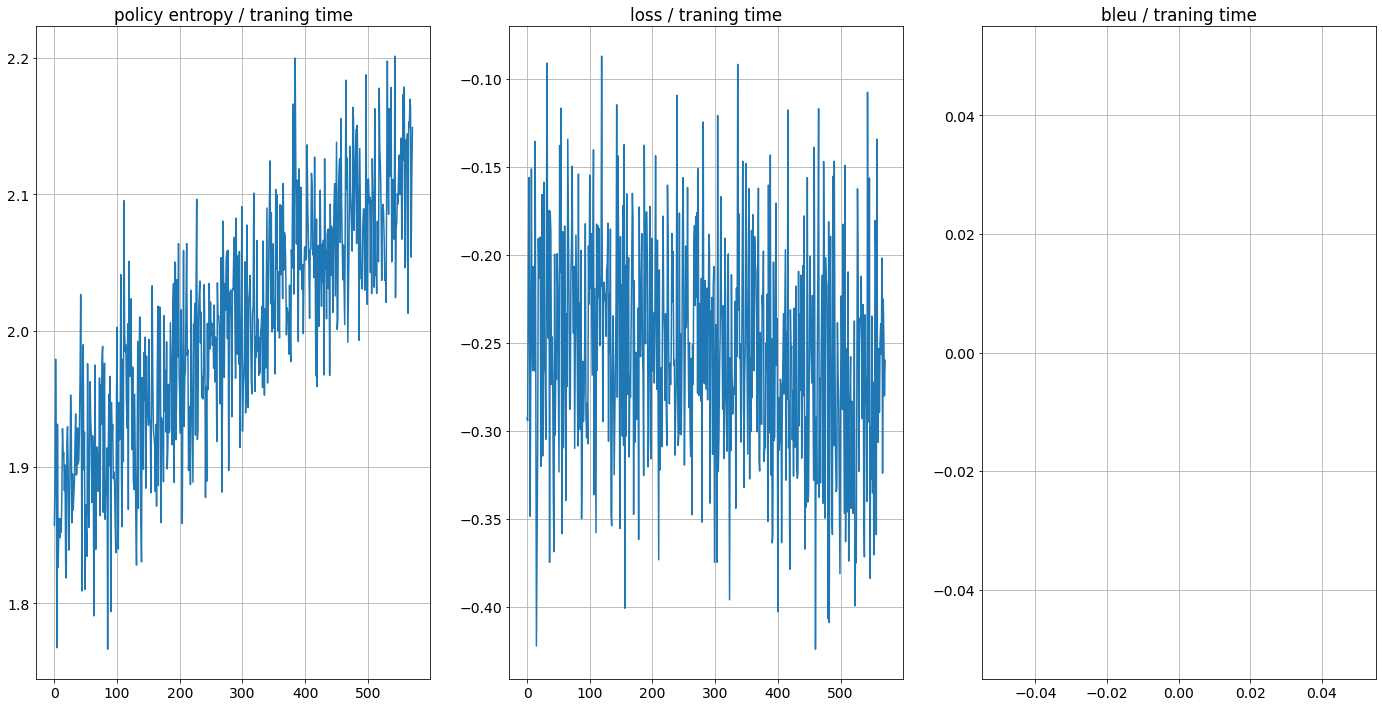

tensor(2.1252, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.0567, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: ignored

In [ ]:

REPORT_FREQ = 2

#batch = next(iter(test_iterator))
for epoch in range(N_EPOCHS):   
   
    
    for i, batch in enumerate(train_iterator):
    
        model.train()        
        src = batch.src
        trg = batch.trg


        #sample_translations, sample_logp = model.translate(src, trg, device, greedy=False)#, max_len=max_len) # YOUR CODE
        #print
        #temp = torch.exp(sample_logp[1][1]) * sample_logp[1][1]
        #print(temp.shape)
        #entropy = -torch.sum(temp)
        #print(entropy)


        #print(sum)

        loss, ent = scst_objective_on_batch(src, trg, device)  # [0] = only source sentence
        #print(loss)
        #break
        #valid_loss = evaluate(model, valid_iterator, criterion)
        #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
       
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        loss_history.append(loss.item())
        entropy_history.append(ent.item())

        #(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)
        #bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
        #bleu_score.append(bleu)

        #debug_list.append(current_scores)
        
        if (i+1) % REPORT_FREQ == 0:
            clear_output(True)
            #current_scores = score(test_words)
            #editdist_history.append(current_scores.mean())
            plt.figure(figsize=(24, 12))
            #plt.subplot(131)
            #plt.title('val score distribution')
            #plt.hist(current_scores, bins=20)
            #plt.subplot(132)
            #plt.title('val score / traning time')
            #plt.plot(editdist_history)
            #plt.grid()
            plt.subplot(131)
            plt.title('policy entropy / traning time')
            plt.plot(entropy_history)
            plt.grid()
            plt.subplot(132)
            plt.title('loss / traning time')
            plt.plot(loss_history)
            plt.grid()

            plt.subplot(133)
            plt.title('bleu / traning time')
            plt.plot(bleu_score)
            plt.grid()

            plt.show()
            #print("J=%.3f, mean score=%.3f" %
            #      (np.mean(loss_history[-10:]), 1)))#np.mean(editdist_history[-10:])))

In [ ]:
(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

In [ ]:
(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)
bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(bleu)
#bleu_score.append(bleu)


30.780659334653315


In [ ]:
(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)
bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(bleu)


30.919835080054426


**В данной  работе была взята исходная модель LSTM + attention,
у которой BLEU был 30.78. Пыталась улучшить метрику BLEU применяя методику Self-critical Sequence Training.**
**В итоге этой работы, мне кажется, мне не очень удалось получить желаемый результат. Коэффициент регуляризации выбрала -0.01. Но лосс по факту падает за счет увеличения энтропии. То есть система начинает предсказывать токены, так скажем, более разнообразно (минимальная энтропия  - когда один токен предсказывается с вероятностью 1, а остальные с вероятностью 0). Энтропия растет судя по графику. А значит за счет регуляризации падает и лосс.**   
**А, как мне кажется, смысл работы был в другом. Энтропию нужно было поддерживать на некотором ненулевом уровне. Чтобы модель, действуя нежадным образом - иногда выбирала, лучшие варианты перевода, чем жадно. В этом случае есть прирост награды.**   
**Я пробовала делать коэффициенты регуляризации и -0.1, и -0.5. И соответственно, чем больше по модулю коэффициент регуляризация, тем больше росла энтропия и падал лосс. В итоге остановилась на коэффициенте -0.01.**   

**В итоге BLEU хоть и повысился, но совсем чуть-чуть - до 30.92**